In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.linear_model as lm
from sklearn import model_selection as ms
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from IPython.display import display
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from sklearn.model_selection import KFold
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from heapq import nsmallest
sns.set_theme()
warnings.filterwarnings('ignore')

In [50]:
train_df = pd.read_csv(r'train.csv')
test_df = pd.read_csv(r'test.csv')

In [51]:
# train_df.info()
categorical = list(train_df.select_dtypes('object').columns)
# categorical

There are 1460 samples in the training data set and 80 features. There are 43 columns with the 'object' data type,
meaning non-numeric categorical data. These features are contained in the "categorical" list. However, notice also that
the 'MSSubClass' feature is numerical-categorical. Thus, there are actually 44 categorical features.

I will select seven non-categorical features.

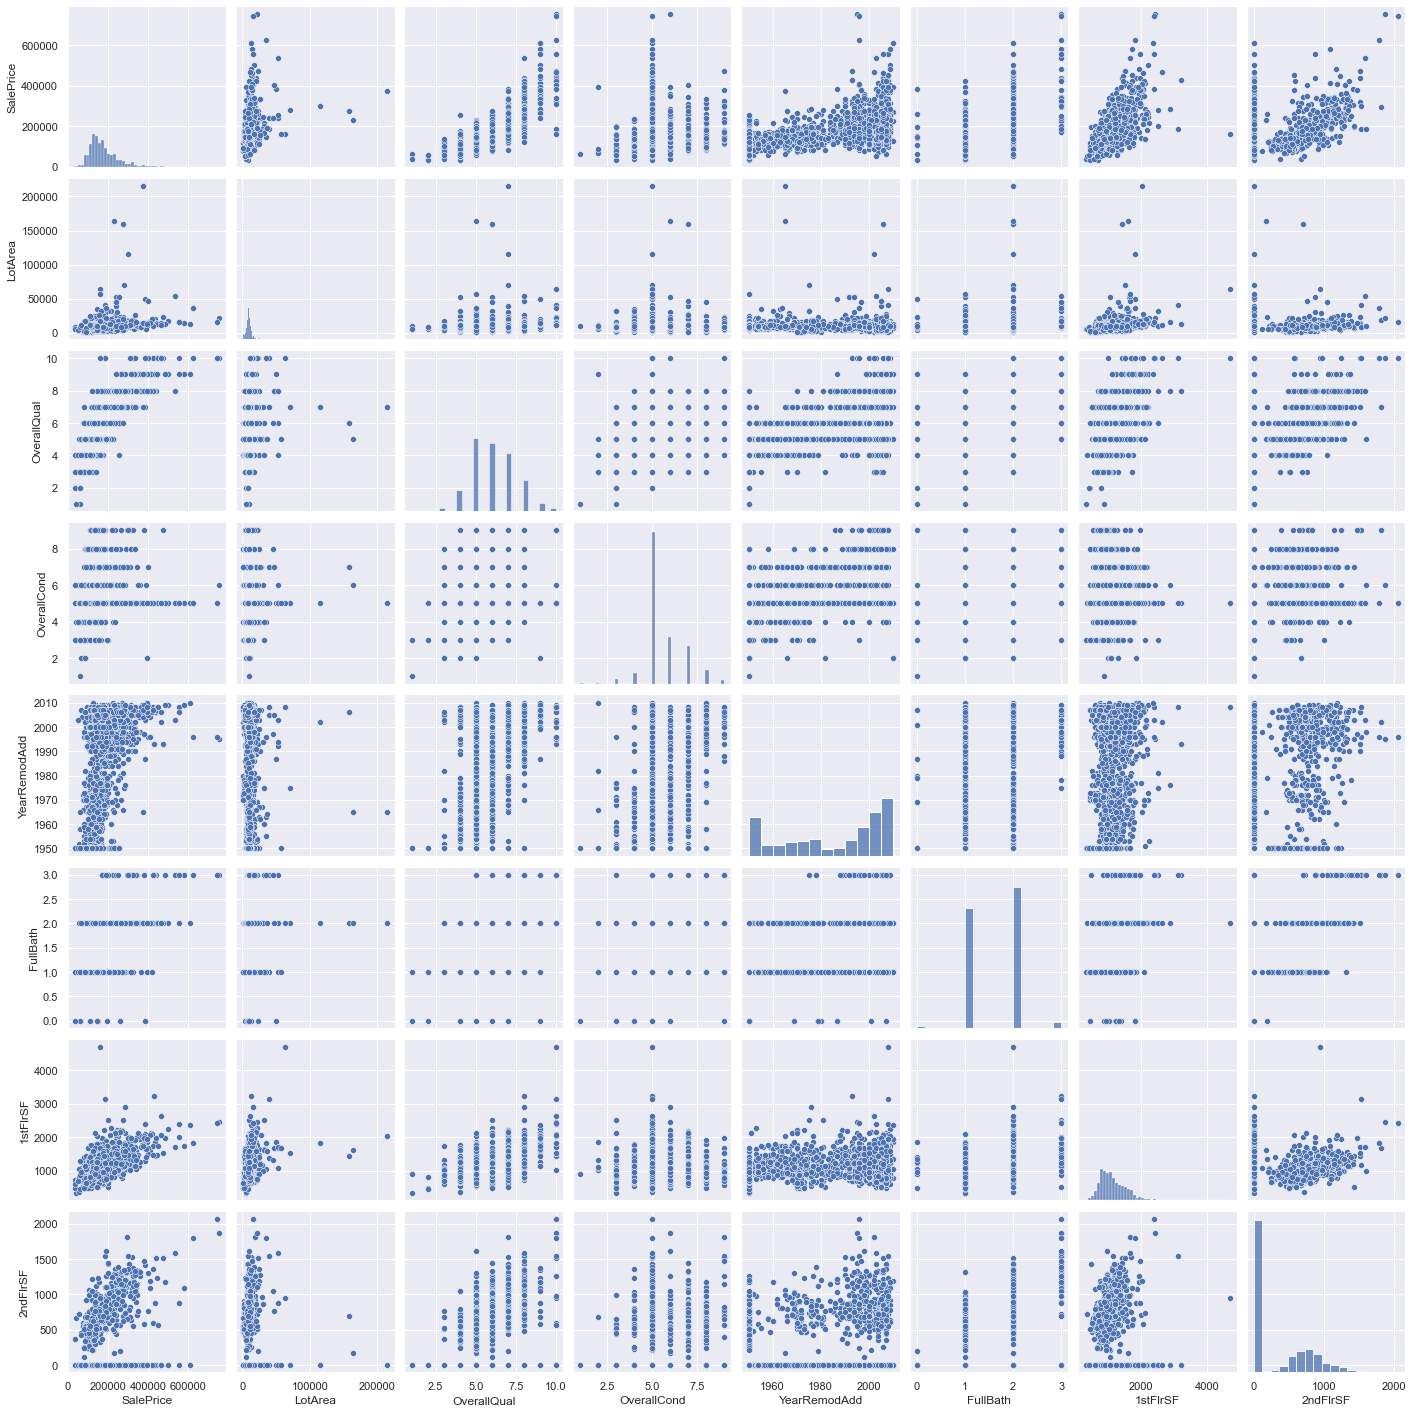

In [52]:
sns.pairplot(train_df[['SalePrice', 'LotArea', 'OverallQual', 'OverallCond', 'YearRemodAdd', 'FullBath', '1stFlrSF', '2ndFlrSF']])

The plots we care about here are in row 1 (or column 1). There appears to be a correlation between sales price and:
Overall Quality, 1st Floor Area, 2nd Floor Area, and some slight correlations with Year of Remodelling, and
Number of Full Baths.

In [53]:
# sm.linear_model.OLS()

One hot encoding:

In [54]:
MSSubClass_encoded = pd.get_dummies(train_df[['MSSubClass']].astype(str))
train_df_dropped = train_df.drop('Id', axis=1)
df_encoded = pd.get_dummies(train_df_dropped)
df_encoded = pd.concat([df_encoded, MSSubClass_encoded], axis=1).drop('MSSubClass', axis=1)
# df_encoded.info(verbose=True, null_counts=True)

In [55]:
split = ms.train_test_split(df_encoded, train_size=0.8, random_state= 17)
train_split_n = split[0]
test_split_n = split[1]
# train_split

In [56]:
# encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
# encoder.fit(train_df)

In [57]:
all_columns = df_encoded.columns
columns = df_encoded.drop(['SalePrice'], axis=1).columns

print('train split missing: ' + str(train_split_n.columns[train_split_n.isna().any()].tolist()))
print('test split missing: ' + str(test_split_n.columns[test_split_n.isna().any()].tolist()))

train split missing: ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']
test split missing: ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']


Setting values to the mean or zeroes could highly skew the results of a regression model.
I will use KNN to perform multivariate imputation, filling in the above columns.

In [58]:
# Training the inputer with train split
imputer_train = KNNImputer(n_neighbors=11, weights="distance")
imputer_train.fit(train_split_n)
train_split = pd.DataFrame(imputer_train.transform(train_split_n), columns = all_columns)
test_split = pd.DataFrame(imputer_train.transform(test_split_n), columns = all_columns)

# display(test_split_n)
# display(test_split)

Now training a normalizer and applying it to the train and test design matrices.

In [59]:
# training the normalizer with train split
normalize_train = StandardScaler().fit(train_split.drop(['SalePrice'], axis=1))

train_norm = normalize_train.transform(train_split.drop(['SalePrice'], axis=1))
test_norm = normalize_train.transform(test_split.drop(['SalePrice'], axis=1))

train_norm = pd.DataFrame(train_norm, columns = columns)
test_norm = pd.DataFrame(test_norm, columns = columns)

# display(train_norm.describe())
# display(test_norm.describe())

In [60]:
X = train_norm
Y = train_split['SalePrice']
X_test = test_norm
Y_test = test_split['SalePrice']

X_non_norm = train_split.drop(['SalePrice'], axis=1)
X_test_non_norm = test_split.drop(['SalePrice'], axis=1)

Performing multivariate linear OLS:

In [61]:
lin_reg = lm.LinearRegression().fit(X_non_norm, Y)
lin_pred = lin_reg.predict(X_test_non_norm)
# lin_reg.score(test_norm.drop(['SalePrice'], axis=1), test_norm['SalePrice'])
r2_score(Y_test, lin_pred)

0.8727037336720768

As we can see, the linear OLS model performs okay. Depending on the randomized train/test split, we get R^2 values
in the 0.8 range. To note, changing the randomized split seed dramatically changes how these models perform because
cross validation was not used for OLS.

Performing KNN with GridSearchCV:

In [62]:
knn_reg = KNeighborsRegressor()
param_grid = {'n_neighbors': np.arange(1, 15)}
knn_grid_cv = ms.GridSearchCV(knn_reg, param_grid, cv=10)
knn_grid_cv.fit(X, Y)
print(knn_grid_cv.best_params_)
print(knn_grid_cv.best_score_)
knn_cv_table = pd.DataFrame(knn_grid_cv.cv_results_)
error = knn_cv_table['std_test_score'].iloc[knn_grid_cv.best_index_]
print(error)

{'n_neighbors': 10}
0.7193525974954694
0.08134924783536315


In [63]:
accept = knn_grid_cv.best_score_ - error
print(accept)
display(knn_cv_table.loc[:,['param_n_neighbors','mean_test_score']])

0.6380033496601063


,param_n_neighbors,mean_test_score
0,1,0.570125
1,2,0.689087
2,3,0.710763
3,4,0.711329
4,5,0.717090
5,6,0.717383
6,7,0.715167
7,8,0.715962
8,9,0.716591
9,10,0.719353


It appears that 10 neighbours gives us the best score at 0.7. However, given the standard error of about 0.06, a score of at least
0.63 performs similarly. Thus, the "rule-of-thumb" best selection could be argued to be k=2 KNN with a score of 0.69.

Trying this model with k=2

In [64]:
knn_reg = KNeighborsRegressor(n_neighbors=2)
knn_reg.fit(X,Y)
Y_pred = knn_reg.predict(X_test)
r2_score(Y_test, Y_pred)

0.7123722453675405

Performing Ridge regression with GridSearchCV

In [65]:
# ridge_reg = lm.RidgeCV(alphas=np.linspace(0.001,1000,30), cv=10)
# ridge_reg.fit(X, Y)
# print(ridge_reg.best_score_)
# print(ridge_reg.alpha_)

In [66]:
ridge_reg = lm.Ridge()
param_grid = {'alpha': np.linspace(0.001,10000,100)}
ridge_grid_cv = ms.GridSearchCV(ridge_reg, param_grid, cv=10)
ridge_grid_cv.fit(X, Y)
print(ridge_grid_cv.best_params_)
print(ridge_grid_cv.best_score_)
print(ridge_grid_cv.best_index_)
ridge_cv_table = pd.DataFrame(ridge_grid_cv.cv_results_)
error = ridge_cv_table['std_test_score'].iloc[ridge_grid_cv.best_index_]
print(error)

{'alpha': 808.0817272727272}
0.8224234736577983
8
0.12347238051877002


In [67]:
accept = ridge_grid_cv.best_score_ - error
print(accept)
display(ridge_cv_table.loc[70:85,['param_alpha','mean_test_score']])
# print(ridge_cv_table[(ridge_cv_table['mean_test_score'] <= accept) & (ridge_cv_table.index > ridge_grid_cv.best_index_)].iloc[0])

0.6989510931390284


,param_alpha,mean_test_score
70,7070.707364,0.713886
71,7171.717455,0.712105
72,7272.727545,0.710329
73,7373.737636,0.708561
74,7474.747727,0.706798
75,7575.757818,0.705043
76,7676.767909,0.703294
77,7777.778,0.701551
78,7878.788091,0.699815
79,7979.798182,0.698086


Our best score here is with lambda or alpha ~ 808.08 with 0.8224. The standard error is 0.1235.
The minimum acceptable score is 0.6990. Looking at our table, this means that our
simplest model (higher lambda) is at index 78 (the lambda within our standard error threshold). This is lambda ~ 7878.79
and CV score = 0.6998.

Trying this model with lambda = 7879

In [68]:
ridge = lm.Ridge(alpha = 7879)
ridge.fit(X,Y)
Y_pred = ridge.predict(X_test)
r2_score(Y_test, Y_pred)

0.7623747489923619

Performing Lasso regression with GridSearchCV

In [69]:
lasso_reg = lm.Lasso()
param_grid = {'alpha': np.linspace(0.001,20000,50)}
lasso_grid_cv = ms.GridSearchCV(lasso_reg, param_grid, cv=10)
lasso_grid_cv.fit(X, Y)
print(lasso_grid_cv.best_params_)
print(lasso_grid_cv.best_score_)
print(lasso_grid_cv.best_index_)
lasso_cv_table = pd.DataFrame(lasso_grid_cv.cv_results_)
error = lasso_cv_table['std_test_score'].iloc[lasso_grid_cv.best_index_]
print(error)

{'alpha': 1632.6539795918368}
0.8116563342572375
4
0.15243216830309633


In [70]:
accept = lasso_grid_cv.best_score_ - error
print(accept)
display(lasso_cv_table.loc[45:55,['param_alpha','mean_test_score']])
# print(lasso_cv_table[(lasso_cv_table['mean_test_score'] <= accept) & (lasso_cv_table.index > lasso_grid_cv.best_index_)].iloc[0])
# lasso_cv_table[['param_alpha', 'mean_test_score']].iloc[30]

0.6592241659541411


,param_alpha,mean_test_score
45,18367.34702,0.671447
46,18775.510265,0.667324
47,19183.67351,0.663097
48,19591.836755,0.658772
49,20000.0,0.654345


Our best score here is with lambda or alpha ~ 1632.65 with 0.8117. The standard CV error is 0.1524.
Thus, the minimum acceptable score is 0.6592. This means that our
simplest model (higher lambda) is at index 47 (the lambda within our standard error threshold).
This is lambda ~ 19183.67 and CV score = 0.663097

Trying this model with lambda = 19184

In [71]:
lasso = lm.Lasso(alpha=19184)
lasso.fit(X,Y)
Y_pred = lasso.predict(X_test)
r2_score(Y_test, Y_pred)

0.6892540092713848

Performing BSR with CV

In [72]:
def evaluate_cv_model(X, Y):
    # xy = pd.concat([X,Y], axis=1)
    # xy = xy.sample(frac=1)
    # X = xy.iloc[:,0:-1]
    # Y = xy.iloc[:,-1]
    reg = lm.LinearRegression()
    param = {'fit_intercept': [True]}
    grid_cv = ms.GridSearchCV(reg, param, cv=10)
    grid_cv.fit(X, Y)
    results = pd.DataFrame(grid_cv.cv_results_)
    score = results['mean_test_score'].iloc[0]
    std = results['std_test_score'].iloc[0]
    return score, std

def get_smallest_z(X ,Y):
    X_sm = sm.add_constant(X, has_constant='add')
    sm_OLS_model = OLS(Y, X_sm)
    result_sm = sm_OLS_model.fit()
    t_df = result_sm.tvalues.to_frame().abs()
    t_df.loc['const',0] = np.inf
    smallest_z_feature = t_df.sort_values(by=[0]).index[0]
    return smallest_z_feature

In [73]:
X_BSR = X_non_norm
k = len(X_BSR.columns)
score_k = np.empty([k-1,3])
dropped_cols = []

# xy = pd.concat([X_BSR,Y], axis=1)
# xy = xy.sample(frac=1)
# X_BSR = xy.iloc[:,0:-1]
# Y = xy.iloc[:,-1]

for iteration in range(len(X_BSR.columns)+1):

    if len(X_BSR.columns) == 1:
        break

    col_to_drop = get_smallest_z(X_BSR, Y)
    # print(col_to_drop)

    if col_to_drop == 'const':
        continue
    else:
        dropped_cols.append(col_to_drop)
        X_BSR = X_BSR.drop(col_to_drop, axis=1)
        k -= 1
        score, std = evaluate_cv_model(X_BSR, Y)
        score_k[iteration,0] = k
        score_k[iteration,1] = score
        score_k[iteration,2] = std
        # print(score)
        # print(k)

Plotting R^2 score as a function of subset size:

(0.6, 0.9)

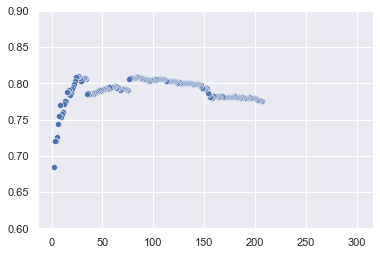

In [74]:
fig = sns.scatterplot(score_k[0:-1,0],score_k[0:-1,1])
fig.set_ylim(0.6,0.9)

With error bars:

(0.0, 120.0)

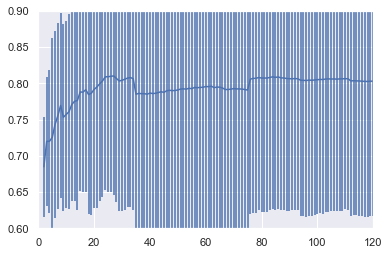

In [75]:
plt.errorbar(score_k[0:-1,0], score_k[0:-1,1], yerr=score_k[0:-1,2])
plt.ylim(0.6, 0.9)
plt.xlim(0,120)

In [76]:
max_BSR = score_k[np.argmax(score_k[0:300,1]),:]
print(np.int(max_BSR[0]))
print(max_BSR[1])
print(max_BSR[2])
print(max_BSR[1] - max_BSR[2])
print(dropped_cols)

27
0.8102432645825729
0.164325104245889
0.6459181603366839
['LotConfig_Corner', 'BsmtUnfSF', 'SaleType_Con', 'ExterCond_Ex', 'MSZoning_RL', 'LotShape_IR3', 'Functional_Maj1', 'BsmtExposure_No', 'Alley_Pave', 'FireplaceQu_Ex', 'MSSubClass_190', 'MSSubClass_20', 'SaleType_New', 'SaleCondition_Normal', 'Exterior1st_Stucco', 'Exterior2nd_Plywood', 'ExterQual_Fa', 'Heating_GasW', 'LandSlope_Mod', 'Foundation_CBlock', 'LandContour_Lvl', 'ExterCond_Po', 'Neighborhood_Veenker', 'SaleType_Oth', 'RoofMatl_Metal', 'PavedDrive_N', 'Condition2_RRNn', 'CentralAir_N', 'Street_Pave', 'BldgType_TwnhsE', 'Utilities_NoSeWa', 'HouseStyle_2.5Unf', 'HouseStyle_1.5Fin', 'Utilities_AllPub', 'HeatingQC_Po', 'RoofStyle_Mansard', 'KitchenQual_Ex', 'Condition1_RRAn', 'GarageYrBlt', 'MiscVal', 'MSZoning_RH', 'Exterior1st_Wd Sdng', 'Foundation_PConc', 'BldgType_Duplex', 'MSSubClass_90', 'BldgType_2fmCon', 'Condition2_RRAn', 'GarageType_Detchd', 'MasVnrType_BrkFace', 'Exterior2nd_Brk Cmn', 'Exterior1st_VinylSd', 'Mi

We see that 27 features is optimal in accuracy at 0.8305. However, the standard error is quite high. This is expected
as linear regression is massively overfitting such a large number of features between our CV folds.
The minimum acceptable score is thus actually 0.64. Examining the score_k array, we can easily see that just two features
are needed to reach this score: The 1st and 2nd Floor Areas.

Is this actually the best idea (using the 1 std. error rule of thumb)? I don't think so. Actually examining the error
between folds of the CV function, I noticed that there were the same 2 or 3 folds that were consistently extremely poor performing.
This is likely some systematic error that is from a dissimilar sample of data. Nevertheless, linear regression appears to have massive
caveats data like this.

Trying OLS with only two features:

In [77]:
BSR = lm.LinearRegression()
BSR.fit(X[['2ndFlrSF', '1stFlrSF']], Y)
Y_pred = BSR.predict(X_test[['2ndFlrSF', '1stFlrSF']])
r2_score(Y_test, Y_pred)

0.586958810759499

The score is as expected - not great at all. The standard error rule of thumb appears to throw off our subset selection.
The high CV error is a sign that the model is overfitting noisy features.

Performing FSR with CV:

In [78]:
X_FSR = X_non_norm
n_cols = len(X_FSR.columns)
score_k = np.zeros([n_cols,3])
cols_try = X_FSR.columns.tolist()
k_set = 0
FSR = lm.LinearRegression()
errors = {}
current_selection = []

def get_RMSE(test_X, Y, FSR):
    FSR.fit(test_X,Y)
    fitted = FSR.predict(test_X)
    return mean_squared_error(Y, fitted)

def get_n_best_features(errors):
    n = 3
    return nsmallest(n, errors, key = errors.get)


for iteration in range(len(X_FSR.columns)+1):

    if len(current_selection) == n_cols:
        break
    if iteration == 0:
        for feature in cols_try:
            errors[feature] = get_RMSE(X_FSR[feature].values.reshape(-1,1), Y, FSR)

        best_features = get_n_best_features(errors)
        cols_try = [x for x in cols_try if x not in best_features]
        current_selection.extend(best_features)
        k_set += len(best_features)
        errors = {}
        # print(k_set)
        score, std = evaluate_cv_model(X_FSR[current_selection], Y)
        # print(current_selection)
        score_k[iteration,0] = k_set
        score_k[iteration,1] = score
        score_k[iteration,2] = std


    else:
        for feature in cols_try:
            errors[feature] = get_RMSE(X_FSR[np.append(current_selection,feature)], Y, FSR)

        best_features = get_n_best_features(errors)
        cols_try = [x for x in cols_try if x not in best_features]
        current_selection.extend(best_features)
        k_set += len(best_features)
        errors = {}
        # print(k_set)
        score, std = evaluate_cv_model(X_FSR[current_selection], Y)
        # print(current_selection)
        score_k[iteration,0] = k_set
        score_k[iteration,1] = score
        score_k[iteration,2] = std

In [79]:
score_k[0:101,1]

array([ 7.24804032e-01,  7.67388857e-01,  7.64417185e-01,  7.71107756e-01,
        7.79845439e-01,  7.92780375e-01,  8.02987980e-01,  8.04819234e-01,
        8.11983880e-01,  8.01748049e-01,  8.04756942e-01,  8.09706537e-01,
        8.09160016e-01,  8.08194549e-01,  8.07446197e-01,  8.10218868e-01,
        8.09757218e-01,  8.12403920e-01,  8.12855012e-01,  8.12262966e-01,
        8.10823943e-01,  8.13706737e-01,  8.11948178e-01,  8.11444832e-01,
        8.08773714e-01,  8.09754827e-01,  8.10088281e-01,  8.09810877e-01,
        8.11202795e-01,  8.09979850e-01,  8.10353032e-01,  8.08812332e-01,
        8.08515048e-01,  8.08244878e-01,  8.08551111e-01,  8.10702398e-01,
       -3.61899376e+09, -9.73643370e+07, -1.39764973e+00, -8.64948093e+08,
       -1.09424034e+08,  7.94489992e-01, -1.12863381e+10,  7.89759397e-01,
       -1.89077973e+03,  7.87707177e-01, -4.24281076e+08, -2.37699663e+01,
       -7.22983338e+02, -6.49206724e+08, -3.06454615e+02, -5.32362666e+06,
       -4.13620333e+06, -

(0.0, 0.9)

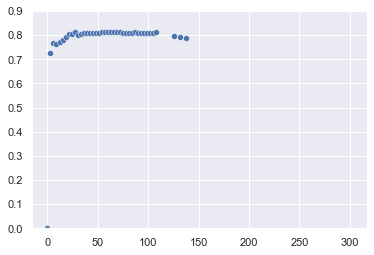

In [80]:
fig2 = sns.scatterplot(score_k[:,0],score_k[:,1])
fig2.set_ylim(0,0.9)

(0.0, 150.0)

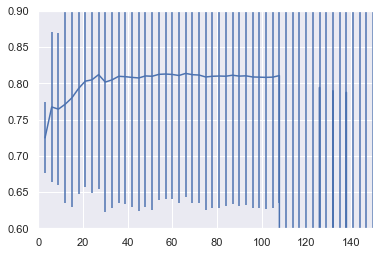

In [81]:
plt.errorbar(score_k[:,0], score_k[:,1], yerr=score_k[:,2])
plt.ylim(0.6, 0.9)
plt.xlim(0,150)

In [82]:
max_FSR = score_k[np.argmax(score_k[:,1]),:]
print(np.int(max_FSR[0]))
print(max_FSR[1])
print(max_FSR[2])
print(max_FSR[1] - max_BSR[2])
print(current_selection)

66
0.813706737297308
0.1710693271935716
0.649381633051419
['OverallQual', 'GrLivArea', 'GarageCars', 'BsmtQual_Ex', 'KitchenQual_Ex', 'BsmtFinSF1', 'RoofMatl_ClyTile', 'Neighborhood_NoRidge', 'Condition2_PosN', 'TotalBsmtSF', 'MSSubClass_20', 'SaleCondition_Partial', 'BsmtExposure_Gd', 'YearRemodAdd', 'KitchenAbvGr', 'Functional_Typ', 'Neighborhood_NridgHt', 'MSZoning_RM', 'RoofMatl_WdShngl', 'OverallCond', 'LotArea', 'YearBuilt', 'Neighborhood_StoneBr', 'BedroomAbvGr', 'Neighborhood_Crawfor', 'BldgType_1Fam', 'ExterQual_Ex', 'PoolQC_Ex', 'PoolArea', 'Neighborhood_Somerst', 'Exterior1st_BrkFace', 'SaleCondition_Abnorml', 'SaleCondition_Normal', 'BsmtExposure_No', 'Condition1_Norm', 'Neighborhood_BrkSide', 'Exterior2nd_VinylSd', 'Exterior1st_VinylSd', 'Functional_Sev', 'LowQualFinSF', 'GarageArea', 'Heating_OthW', 'GarageFinish_RFn', 'Street_Pave', 'Street_Grvl', 'Neighborhood_Mitchel', 'ScreenPorch', 'GarageQual_TA', 'GarageQual_Fa', 'PoolQC_Fa', 'Fence_GdPrv', 'PoolQC_Gd', 'HeatingQC_

The optimum appears to be 0.81 @66 features, however the rule of thumb tells us that 0.65 is sufficient. This
can be achieved with actually only one feature, Overall Quality. Again, the reason being is that the cross validation
error is extremely high. There are some folds in the data that seem to have massive error, making our estimates of
R^2 score effectively meaningless. This appears to be a big limitation of the CV error rule of thumb estimate.

Trying only one feature:

In [83]:
FSR = lm.LinearRegression()
FSR.fit(X['OverallQual'].values.reshape(-1, 1), Y)
Y_pred = FSR.predict(X_test['OverallQual'].values.reshape(-1, 1))
r2_score(Y_test, Y_pred)

0.6255725557689975

The score is not great either, for the same reasons as in BSR. However, we do know that it is not overfitting the data
as much as full subset OLS.

Adding quadratic features

In [84]:
quadratic = PolynomialFeatures(degree=2)

quadratic.fit(X)
X = quadratic.transform(X)
X_test = quadratic.transform(X_test)

quadratic.fit(X_non_norm)
X_non_norm = quadratic.transform(X_non_norm)
X_test_non_norm = quadratic.transform(X_test_non_norm)

np.shape(X)

(1168, 46056)

Quadratic OLS:

In [85]:
lin_reg = lm.LinearRegression().fit(X, Y)
lin_pred = lin_reg.predict(X_test)
# lin_reg.score(test_norm.drop(['SalePrice'], axis=1), test_norm['SalePrice'])
r2_score(Y_test, lin_pred)

0.7474313794179943

OLS is slightly lower score with quadratic features. Likely overfitting the high amount of features.

Performing KNN with GridSearchCV:

In [86]:
knn_reg = KNeighborsRegressor()
param_grid = {'n_neighbors': np.arange(1, 15)}
knn_grid_cv = ms.GridSearchCV(knn_reg, param_grid, cv=10)
knn_grid_cv.fit(X, Y)
print(knn_grid_cv.best_params_)
print(knn_grid_cv.best_score_)
knn_cv_table = pd.DataFrame(knn_grid_cv.cv_results_)
error = knn_cv_table['std_test_score'].iloc[knn_grid_cv.best_index_]
print(error)

{'n_neighbors': 2}
0.5336591823545344
0.12174820953358002


In [87]:
accept = knn_grid_cv.best_score_ - error
print(accept)
display(knn_cv_table.loc[:,['param_n_neighbors','mean_test_score']])

0.41191097282095435


,param_n_neighbors,mean_test_score
0,1,0.422811
1,2,0.533659
2,3,0.531930
3,4,0.520597
4,5,0.506649
5,6,0.482345
6,7,0.467958
7,8,0.453898
8,9,0.434273
9,10,0.419833


It appears that 2 neighbours gives us the best score at 0.53. Acceptable is 0.41. k=1 appears optimal. Of course,
this is only because of all the overfitting.

Trying this model with k=1

In [88]:
knn_reg = KNeighborsRegressor(n_neighbors=1)
knn_reg.fit(X,Y)
Y_pred = knn_reg.predict(X_test)
r2_score(Y_test, Y_pred)

0.5705008823109943

The model performs substantially worse than linear OLS. The limits of dimensionality while using KNN is apparent here.

Performing Ridge regression with GridSearchCV. Number of parameters reduced for speed.

In [89]:
# ridge_reg = lm.RidgeCV(alphas=np.linspace(0.001,1000,30), cv=10)
# ridge_reg.fit(X, Y)
# print(ridge_reg.best_score_)
# print(ridge_reg.alpha_)

In [90]:
ridge_reg = lm.Ridge()
param_grid = {'alpha': np.linspace(0.001,1000000,15)}
ridge_grid_cv = ms.GridSearchCV(ridge_reg, param_grid, cv=10)
ridge_grid_cv.fit(X, Y)
print(ridge_grid_cv.best_params_)
print(ridge_grid_cv.best_score_)
print(ridge_grid_cv.best_index_)
ridge_cv_table = pd.DataFrame(ridge_grid_cv.cv_results_)
error = ridge_cv_table['std_test_score'].iloc[ridge_grid_cv.best_index_]
print(error)

{'alpha': 71428.57235714285}
0.6612651661924351
1
0.15320456590894932


In [91]:
accept = ridge_grid_cv.best_score_ - error
print(accept)
display(ridge_cv_table.loc[0:20,['param_alpha','mean_test_score']])
# print(ridge_cv_table[(ridge_cv_table['mean_test_score'] <= accept) & (ridge_cv_table.index > ridge_grid_cv.best_index_)].iloc[0])

0.5080606002834858


,param_alpha,mean_test_score
0,0.001,0.658305
1,71428.572357,0.661265
2,142857.143714,0.597834
3,214285.715071,0.545649
4,285714.286429,0.502259
5,357142.857786,0.465578
6,428571.429143,0.434116
7,500000.0005,0.406798
8,571428.571857,0.382832
9,642857.143214,0.361617


Our best score here is with lambda = very large. Rule of thumb tells us that the best lambda is about 214000


Trying this model with lambda = 214000

In [92]:
ridge = lm.Ridge(alpha = 214000)
ridge.fit(X,Y)
Y_pred = ridge.predict(X_test)
r2_score(Y_test, Y_pred)

0.6191475191708875

Somewhat poor performance again, especially compared to the linear model. But it is better due to regularization

Performing Lasso regression with GridSearchCV

In [93]:
lasso_reg = lm.Lasso()
param_grid = {'alpha': np.linspace(0.001,40000,15)}
lasso_grid_cv = ms.GridSearchCV(lasso_reg, param_grid, cv=10)
lasso_grid_cv.fit(X, Y)
print(lasso_grid_cv.best_params_)
print(lasso_grid_cv.best_score_)
print(lasso_grid_cv.best_index_)
lasso_cv_table = pd.DataFrame(lasso_grid_cv.cv_results_)
error = lasso_cv_table['std_test_score'].iloc[lasso_grid_cv.best_index_]
print(error)

{'alpha': 11428.572142857143}
0.7498468989928895
4
0.1269213358663899


In [94]:
accept = lasso_grid_cv.best_score_ - error
print(accept)
display(lasso_cv_table.loc[0:15,['param_alpha','mean_test_score']])
# print(lasso_cv_table[(lasso_cv_table['mean_test_score'] <= accept) & (lasso_cv_table.index > lasso_grid_cv.best_index_)].iloc[0])
# lasso_cv_table[['param_alpha', 'mean_test_score']].iloc[30]

0.6229255631264996


,param_alpha,mean_test_score
0,0.001,-101.675376
1,2857.143786,0.639095
2,5714.286571,0.676692
3,8571.429357,0.728859
4,11428.572143,0.749847
5,14285.714929,0.737036
6,17142.857714,0.708343
7,20000.0005,0.675373
8,22857.143286,0.637929
9,25714.286071,0.596218


Best score is at lambda ~ 14000. Optimal rule of thumb: 22000

Trying this model with lambda = 22000

In [95]:
lasso2 = lm.Lasso(alpha=22000)
lasso2.fit(X,Y)
Y_pred = lasso2.predict(X_test)
r2_score(Y_test, Y_pred)

0.6655898762575876

The model performs okay due to the regularization of numerous features, simplifying the model.

Linear Lasso coefficients:

In [96]:
retained = np.nonzero(lasso.coef_)
columns[[retained]][0]

array(['OverallQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea',
       'GarageCars', 'GarageArea', 'BsmtQual_Ex'], dtype=object)

Quadratic Lasso coefficients:

In [97]:
q_cols = quadratic.get_feature_names()
np.shape(X)

(1168, 46056)

In [98]:
retained = np.nonzero(lasso2.coef_)
b = list(retained)[0].tolist()
T = [q_cols[i] for i in b]
len(T)
print(list(T))

['x2', 'x14', 'x1^2', 'x6^2', 'x20^2', 'x31^2', 'x35^2', 'x42^2', 'x45^2', 'x63^2', 'x64^2', 'x66^2', 'x68^2', 'x69^2', 'x71^2', 'x72^2', 'x77^2', 'x78^2', 'x79^2', 'x83^2', 'x84^2', 'x85^2', 'x86^2', 'x87^2', 'x96^2', 'x97^2', 'x99^2', 'x100^2', 'x102^2', 'x105^2', 'x110^2', 'x122^2', 'x123^2', 'x125^2', 'x127^2', 'x129^2', 'x130^2', 'x130 x248', 'x131^2', 'x132^2', 'x133^2', 'x135^2', 'x135 x150', 'x141^2', 'x150^2', 'x153 x261', 'x155^2', 'x165^2', 'x166^2', 'x167^2', 'x171^2', 'x173^2', 'x178^2', 'x179^2', 'x181^2', 'x182^2', 'x187^2', 'x190^2', 'x205^2', 'x208^2', 'x209^2', 'x210^2', 'x216^2', 'x216 x217', 'x217^2', 'x219^2', 'x220^2', 'x223^2', 'x224^2', 'x228^2', 'x232^2', 'x234^2', 'x242^2', 'x243^2', 'x249^2', 'x250^2', 'x257^2', 'x259^2', 'x261^2', 'x267^2', 'x269^2', 'x271^2', 'x274^2', 'x279^2', 'x282^2', 'x286^2', 'x289^2', 'x292^2', 'x294^2']


We can see that only the above features are being retained. This somewhat makes sense. Overall Quality, 1st Flr Area,
Basement Area, etc. all seem somewhat important to house valuation. Of course, this does not agree with our stepwise
models, the reason being the high CV error throwing off our subset selection.

I predicted that Overall Quality and 1st Flr Area would be important, and was correct in that.

The Quadratic coefficients are harder to decipher. Out of 46056 features, only 89 were not regularized away. That being
said, many quadratic features were retained. This tells us that some features may benefit from higher order fitting.

Although Linear OLS performed the best, I will elect to use Ridge Regression with lambda = 7879 to prevent overfitting.

Training on our entire set of data.

In [99]:
id_list = test_df['Id']

In [100]:
def transform_x(dataframe):
    X = dataframe
    MSSubClass_encoded = pd.get_dummies(X[['MSSubClass']].astype(str))
    X = pd.get_dummies(X)
    X = pd.concat([X, MSSubClass_encoded], axis=1).drop('MSSubClass', axis=1)

    columns = X.columns

    imputer_train = KNNImputer(n_neighbors=11, weights="distance")
    imputer_train.fit(X)
    X = pd.DataFrame(imputer_train.transform(X), columns = columns)

    normalize_train = StandardScaler().fit(X)
    X = normalize_train.transform(X)
    X = pd.DataFrame(X, columns = columns)

    return X

In [101]:
X_train_final = train_df.drop(['Id', 'SalePrice'], axis=1)
X_train_final = transform_x(X_train_final)
train_col = X_train_final.columns.tolist()

In [102]:
X_test_final = test_df.drop('Id', axis=1)
X_test_final = transform_x(X_test_final)
test_col = X_test_final.columns.tolist()

In [103]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

cols_use = intersection(train_col, test_col)

In [104]:
final_model = lm.Ridge(alpha=7879)
final_model.fit(X_train_final[cols_use], train_df['SalePrice'])
Y_pred_final = final_model.predict(X_test_final[cols_use])

predictions = pd.DataFrame({'Id': id_list, 'SalePrice': Y_pred_final})
predictions.to_csv('predictions_house.csv', index=False)